# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation

# Load model

In [2]:
# Define model file input path
input_path = '../data/travis-county-lo-res-model-patched.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

In [3]:
model_collection.models

{'travis': <tx_fast_hydrology.muskingum.Muskingum at 0x141f34110>}

In [4]:
model = model_collection.models['travis']

Text(0.5, 1.0, 'Stream network')

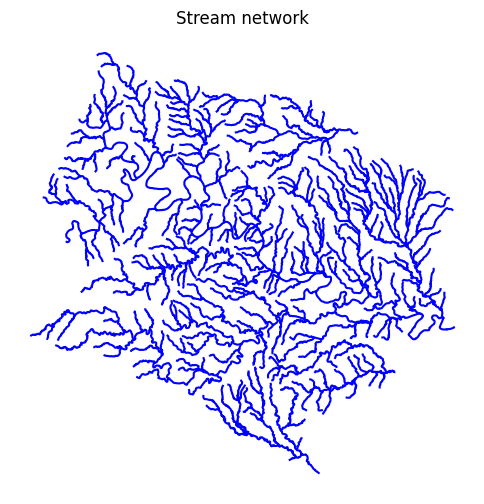

In [5]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
model.plot(ax=ax, c='b')
_ = plt.axis('off')
plt.title('Stream network')

# Run impulse response

In [6]:
n_steps = 1000

# Initialize model states
model.init_states(o_t_next=np.ones(model.n))
model.save_state()

# Create dict to store outputs
outputs = {}
outputs[model.datetime] = model.o_t

p_t_next = np.zeros(model.n, dtype=np.float64)
# Step model forward in time
for _ in range(n_steps):
    model.step(p_t_next)
    o_t = model.o_t
    outputs[model.datetime] = o_t
# Format outputs as dataframe
outputs = pd.DataFrame.from_dict(outputs, orient='index')
outputs.columns = model.reach_ids
outputs.index = pd.to_datetime(outputs.index, utc=True)

Text(0.5, 1.0, 'Impulse response')

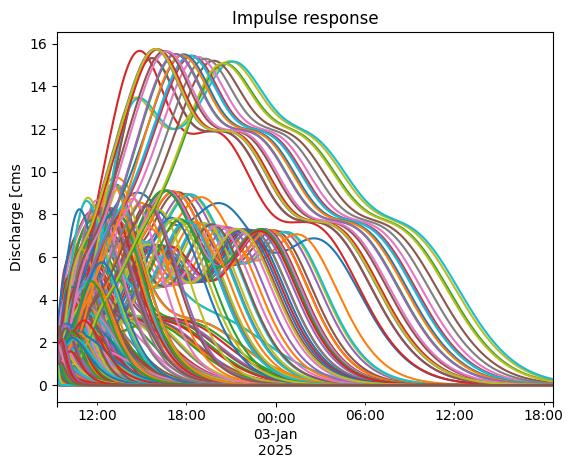

In [7]:
outputs.plot(legend=False)
plt.ylabel('Discharge [cms')
plt.title('Impulse response')

# Run step response

In [8]:
# Reset model to starting state and time
model.load_state()
# Create input forcing data (step input)
date_range = pd.date_range(model.datetime + model.timedelta, periods=n_steps, freq=model.timedelta)
inputs = pd.DataFrame(1., columns=model.reach_ids, index=date_range)
# Create simulation
model_collection = ModelCollection([model], name='travis-county')
simulation = AsyncSimulation(model_collection, inputs)
# Simulate model
outputs = await simulation.simulate()
# Collect outputs into a single table
outputs = pd.concat([series for series in outputs.values()], axis=1)

Text(0.5, 1.0, 'Step response')

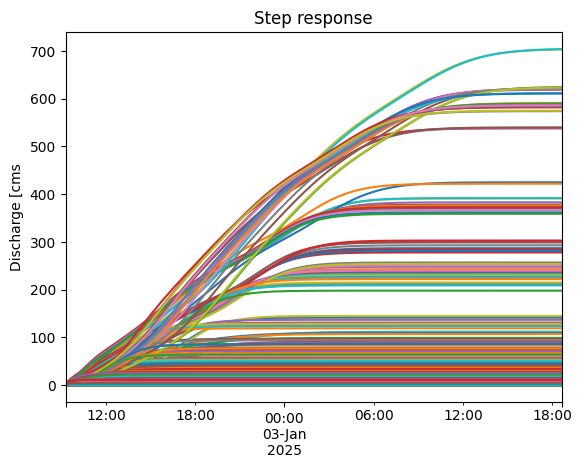

In [9]:
outputs.plot(legend=False)
plt.ylabel('Discharge [cms')
plt.title('Step response')

# Plot discharges

In [10]:
nwm_streams_tx = gpd.read_file('../data/nwm_streams_tx')
nwm_streams_tx['ID'] = nwm_streams_tx['ID'].astype(int).astype(str)
nwm_streams_travis = nwm_streams_tx[nwm_streams_tx['ID'].isin(model.reach_ids)].copy()

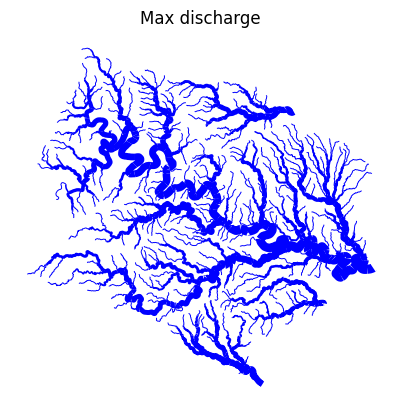

In [11]:
fig, ax = plt.subplots()
nwm_streams_travis['flow'] = nwm_streams_travis['ID'].map(outputs.max(axis=0)).fillna(0.).values
nwm_streams_travis.plot(ax=ax, color='b', zorder=3, 
                        linewidth=1*np.log(1 + nwm_streams_travis['flow'].values))
plt.title('Max discharge')
_ = plt.axis('off')